INITIALIZING TPU

In [1]:
# creating TPU environment to create model architecture and initialize architecture's variable on TPU
import os
import tensorflow as tf

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
# create a distribution stratagy
strategy = tf.distribute.TPUStrategy(resolver)

INFO:tensorflow:Initializing the TPU system: grpc://10.125.63.2:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.125.63.2:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


IMPORTING IMPORTANT MODULES

In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers
import time

from tensorflow.keras.models import  Sequential, load_model

LOADING DATASET

In [3]:
(x,_),(_,_) = fashion_mnist.load_data()
x = x.reshape(x.shape[0], 28, 28, 1).astype('float32')
x = x/np.float32(255)
print(x.shape)
BUFFER_SIZE = 60000
BATCH_SIZE = 256
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(x).batch(BATCH_SIZE)

4423680/4422102 [==============================] - 0s 0us/step
(60000, 28, 28, 1)


(28, 28, 1)


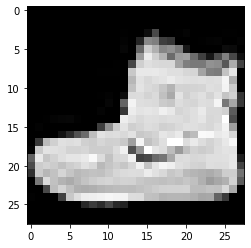

In [4]:
for i in train_dataset:
  print(i[0].shape)
  plt.imshow(i[0][:,:,0]*255, cmap='gray')
  break


In [5]:
GLOBAL_BATCH_SIZE = BATCH_SIZE * strategy.num_replicas_in_sync

MODEL CREATION

In [6]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation="softmax"))

    return model

CUSTOM TRAINING METHOD (OVER-RIDING FIT METHOD OF KERAS)

In [7]:
class GAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = tf.keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = tf.keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        #****************************************--DISCRIMINATOR HANDLING--*******************
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat([ tf.zeros((batch_size, 1)), tf.ones((batch_size, 1))], axis=0)
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = tf.nn.compute_average_loss(self.loss_fn(labels, predictions), global_batch_size=GLOBAL_BATCH_SIZE)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        #***************************************--GENERATOR HANDLING--***********************
        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.ones((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = tf.nn.compute_average_loss(self.loss_fn(misleading_labels, predictions), global_batch_size=GLOBAL_BATCH_SIZE)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {"d_loss": self.d_loss_metric.result(),"g_loss": self.g_loss_metric.result()}


CALLBACK METHOD OVERRIDE


In [21]:
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

class GANMonitor(tf.keras.callbacks.Callback):
    def __init__(self, seed):
        self.seed = seed

    def on_epoch_end(self, epoch, logs=None):
        # generated_images = self.model.generator(random_latent_vectors)
        # generated_images *= 255
        # generated_images.numpy()
        # for i in range(self.num_img):
        #     img = keras.preprocessing.image.array_to_img(generated_images[i])
        #     img.save("generated_img_%03d_%d.png" % (epoch, i))
        #     img.show()
        
        predictions = self.model.generator(seed)

        fig = plt.figure(figsize=(6, 6))

        for i in range(predictions.shape[0]):
            plt.subplot(4, 4, i+1)
            plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
            plt.axis('off')

        plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
        #plt.show()


INITIALIZING MODEL

In [22]:
with strategy.scope():
  #create generator and discriminator model modal
  #generator = make_generator_model()
  #discriminator = make_discriminator_model()
  
  #use below 2 lines of code if model is already trained and saved somewhere
  generator = load_model('/content/drive/MyDrive/Colab Notebooks/gan_/generator_tpu.h5')
  discriminator = load_model('/content/drive/MyDrive/Colab Notebooks/gan_/discriminator_tpu.h5')
  
  gan = GAN(discriminator=discriminator, generator=generator, latent_dim=100)

  gan.compile(
      d_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5),
      g_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5),
      loss_fn=tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
  )

TRAINING.......................................

In [ ]:
gan.fit(train_dataset, epochs=50, batch_size=BATCH_SIZE, callbacks=[GANMonitor(seed=seed)])

SAVING MODEL

In [ ]:
generator.save('/content/drive/MyDrive/Colab Notebooks/gan_/generator_tpu.h5')
discriminator.save('/content/drive/MyDrive/Colab Notebooks/gan_/discriminator_tpu.h5')

VISUALIZING THE GENERATED IMAGES PER EPOCH

In [27]:
import glob
import imageio

anim_file = '/content/drive/MyDrive/Colab Notebooks/gan_/dcgan_tpu.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)

In [28]:
from IPython.display import Image
Image(open(anim_file,'rb').read())

Output hidden; open in https://colab.research.google.com to view.

CHANGING FPS TO VISUALIZE MORE BETTER

In [42]:
gif = imageio.mimread(anim_file)
speed_up_gif = '/content/drive/MyDrive/Colab Notebooks/gan_/dcgan_tpu_fps.gif'
imageio.mimsave(speed_up_gif, gif, fps=1)

In [43]:
from IPython.display import Image
Image(open(speed_up_gif,'rb').read())

Output hidden; open in https://colab.research.google.com to view.

DOWNLOADING DATA FROM KAGGLE

In [48]:
#way to download kaggle dataset in google drive
#config
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Colab Notebooks/gan_" #path to where kaggle.json is located
#download dataset
!kaggle datasets download -d soumikrakshit/anime-faces

anime-faces.zip: Skipping, found more recently modified local copy (use --force to force download)


In [52]:
from zipfile import ZipFile
with ZipFile("anime-faces.zip", "r") as zipobj:
    zipobj.extractall("anime_faces")